In [1]:
from moabb.datasets import MAMEM3

dataset = MAMEM3()
interval = dataset.interval

## Algorithm 1: Canonical correlation analysis

In [2]:
from moabb.paradigms import SSVEP

n_classes=3
paradigm_bandpass = SSVEP(fmin=3, fmax=45, n_classes=n_classes)
freqs = paradigm_bandpass.used_events(dataset)
print(freqs)

Choosing the first 3 classes from all possible events


{'6.66': 33029, '7.50': 33028, '8.57': 33027}


In [3]:
from sklearn.pipeline import make_pipeline
from moabb.pipelines import SSVEP_CCA
from moabb.pipelines import ExtendedSSVEPSignal


pipelines_bandpass = dict()
pipelines_bandpass["CCA"] = make_pipeline(
    SSVEP_CCA(interval=interval, freqs=freqs, n_harmonics=2)
)

## Algorithm 2: Task-related correlation analysis

In [13]:
from moabb.pipelines import SSVEP_TRCA


pipelines_bandpass["TRCA"] = make_pipeline(
    SSVEP_TRCA(interval=interval, freqs=freqs, n_fbands=5, estimator='lwf')
    
)


## Algorithm 3: Riemannian Geometry

In [5]:
from moabb.paradigms import FilterBankSSVEP

filter_freqs = [
    6.66, 6.66*2,
    7.50, 7.50*2,
    8.57, 8.57*2,
]
filters = [[f-.5, f+.5] for f in filter_freqs]

paradigm_filterbank = FilterBankSSVEP(n_classes=n_classes, filters=filters)

Choosing the first 3 classes from all possible events


In [6]:
from moabb.pipelines import ExtendedSSVEPSignal
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from sklearn.linear_model import LogisticRegression

pipelines_filterbank = dict()
pipelines_filterbank["RG+logreg"] = make_pipeline(
    ExtendedSSVEPSignal(),
    Covariances(estimator="lwf"),
    TangentSpace(),
    LogisticRegression(solver="lbfgs", multi_class="auto"),
)


## Algorithm 4: Frequency band power

In [7]:
paradigm_filterbank_baseline = FilterBankSSVEP(n_classes=n_classes, tmin=-3, filters=filters)

Choosing the first 3 classes from all possible events


In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.preprocessing import FunctionTransformer
import ipdb

def baseline_ratio(X, y=None, sfreq=128, tmin=-3, baseline=(-2.5, -.5)):
    baseline_start = int((baseline[0]-tmin)*sfreq)
    baseline_end = int((baseline[1]-tmin)*sfreq)        
    baseline_period = X[:,:,baseline_start:baseline_end,:]
    stim_start = max(0, int(-tmin*sfreq))
    stimulation_period = X[:,:,stim_start:,:]
    baseline_power = np.mean(baseline_period**2, axis=(1,2))
    stimulation_power = np.mean(stimulation_period**2, axis=(1,2))
    return stimulation_power/baseline_power

pipelines_filterbank_baseline = dict()
pipelines_filterbank_baseline['power+logreg'] = make_pipeline(
    FunctionTransformer(baseline_ratio),
    FunctionTransformer(np.log),
    LogisticRegression(solver="lbfgs", multi_class="auto"),
)

## Evaluate algorithm performance

In [ ]:
from moabb.evaluations import WithinSessionEvaluation

evaluation_bandpass = WithinSessionEvaluation(
    paradigm=paradigm_bandpass,
    datasets=dataset,
    suffix="ssvep_workshop_whithin_session_bandpass",
    overwrite=True
)
results_bandpass = evaluation_bandpass.process(pipelines_bandpass)
results_bandpass

SSVEP MAMEM3-WithinSession:  80%|▊| 8/10

In [10]:
evaluation_filterbank = WithinSessionEvaluation(
    paradigm=paradigm_filterbank,
    datasets=dataset,
    suffix="ssvep_workshop_whithin_session_filterbank",
    overwrite=False
)
results_filterbank = evaluation_filterbank.process(pipelines_filterbank)
results_filterbank

SSVEP MAMEM3-WithinSession: 100%|█| 10/1


,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
0,0.844444,1.645173,45.0,1,session_0,14,1,SSVEP MAMEM3,RG+logreg
1,0.888889,1.360557,45.0,2,session_0,14,1,SSVEP MAMEM3,RG+logreg
2,0.355556,2.017418,45.0,3,session_0,14,1,SSVEP MAMEM3,RG+logreg
3,0.777778,1.630761,45.0,4,session_0,14,1,SSVEP MAMEM3,RG+logreg
4,0.577778,2.488468,45.0,5,session_0,14,1,SSVEP MAMEM3,RG+logreg
5,0.577778,1.395220,45.0,6,session_0,14,1,SSVEP MAMEM3,RG+logreg
6,0.555556,1.432244,45.0,7,session_0,14,1,SSVEP MAMEM3,RG+logreg
7,0.266667,1.679574,45.0,8,session_0,14,1,SSVEP MAMEM3,RG+logreg
8,0.800000,2.258481,45.0,9,session_0,14,1,SSVEP MAMEM3,RG+logreg
9,0.933333,1.720083,45.0,10,session_0,14,1,SSVEP MAMEM3,RG+logreg


In [11]:
evaluation_filterbank = WithinSessionEvaluation(
    paradigm=paradigm_filterbank_baseline,
    datasets=dataset,
    suffix="ssvep_workshop_whithin_session_filterbank_baseline",
    overwrite=True
)
results_filterbank_baseline = evaluation_filterbank.process(pipelines_filterbank_baseline)
results_filterbank_baseline

SSVEP MAMEM3-WithinSession: 100%|█| 10/1


,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
0,0.577778,0.010305,45.0,1,session_0,14,1,SSVEP MAMEM3,power+logreg
1,0.511111,0.010111,45.0,2,session_0,14,1,SSVEP MAMEM3,power+logreg
2,0.555556,0.010073,45.0,3,session_0,14,1,SSVEP MAMEM3,power+logreg
3,0.444444,0.009915,45.0,4,session_0,14,1,SSVEP MAMEM3,power+logreg
4,0.511111,0.009887,45.0,5,session_0,14,1,SSVEP MAMEM3,power+logreg
5,0.555556,0.010953,45.0,6,session_0,14,1,SSVEP MAMEM3,power+logreg
6,0.511111,0.011738,45.0,7,session_0,14,1,SSVEP MAMEM3,power+logreg
7,0.511111,0.010168,45.0,8,session_0,14,1,SSVEP MAMEM3,power+logreg
8,0.666667,0.010414,45.0,9,session_0,14,1,SSVEP MAMEM3,power+logreg
9,0.466667,0.009962,45.0,10,session_0,14,1,SSVEP MAMEM3,power+logreg


(0.0, 1.0)

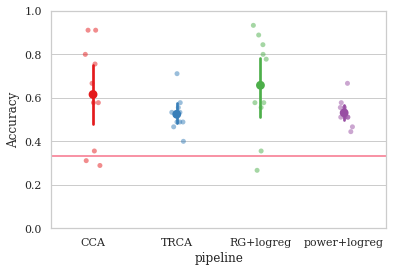

In [12]:
import seaborn as sns
import pandas as pd

results = pd.concat([results_bandpass, results_filterbank, results_filterbank_baseline])
ax = sns.stripplot(data=results, y="score", x="pipeline", zorder=1, alpha=.5, palette="Set1")
ax = sns.pointplot(data=results, y="score", x="pipeline" , palette="Set1")
ax.set_ylabel("Accuracy")
ax.axhline(1/n_classes)
ax.set_ylim(0,1)